In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV

### Main Features Analysis

d:\Documents\sigmoid_assignments\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


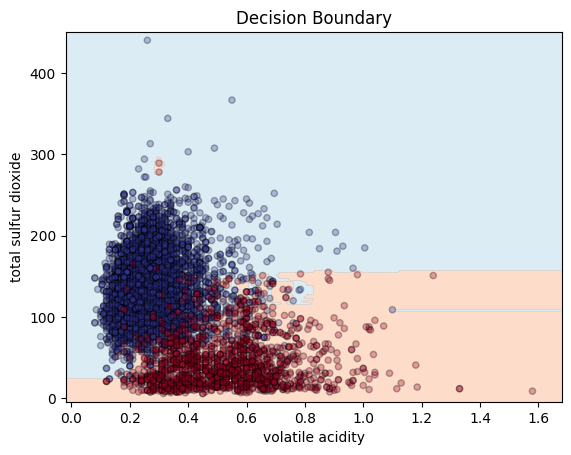

In [4]:
df = pd.read_csv('data/wine.csv')
df = pd.get_dummies(df,drop_first=True)

#2 main features
X = df[['volatile acidity', 'total sulfur dioxide']]
y = df['type_white']

model = RandomForestClassifier(random_state=42).fit(X, y)

# Create mesh grid
x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
y_min, y_max = X.iloc[:, 1].min() - 10, X.iloc[:, 1].max() + 10
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on mesh
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='RdYlBu', edgecolors='k', s=20,alpha=0.3)
plt.xlabel('volatile acidity')
plt.ylabel('total sulfur dioxide')
plt.title('Decision Boundary')
plt.show()

Compared to the Decision Tree model the Random Forest model has a more precise, less likely to overfit boundary. The 2 dots mentioned to falsely create a boundary in the previous notebook now have a much smaller influence on the model, and the comparison has brought to my attention that one "white wine" instance which used to separate a large boundry within the "red wine" territory in the Decision Tree implementation, likely due to the sparseness of data in that area, now only separates a small segment.

### Baseline Model


In [ ]:
X = df.drop('type_white', axis=1)
y = df['type_white']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hyperparameters =  {
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'min_weight_fraction_leaf': 0.0,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0
}

model = RandomForestClassifier(random_state=42, **hyperparameters).fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train))
test_score = accuracy_score(y_test, model.predict(X_test))

#Feature importance
feature_imp=pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

print(f"Train Accuracy: {train_score:.4f} --- Test Accuracy: {test_score:.4f}")
print("\nFeature Importances:")
print(feature_imp)


Train Accuracy: 0.9935 --- Test Accuracy: 0.9931

Feature Importances:
total sulfur dioxide    0.655167
chlorides               0.246978
volatile acidity        0.033334
density                 0.020646
fixed acidity           0.018524
sulphates               0.011288
pH                      0.006321
residual sugar          0.004632
alcohol                 0.001862
citric acid             0.000976
free sulfur dioxide     0.000187
quality                 0.000086
dtype: float64


### Manual Hyperparameter Tuning


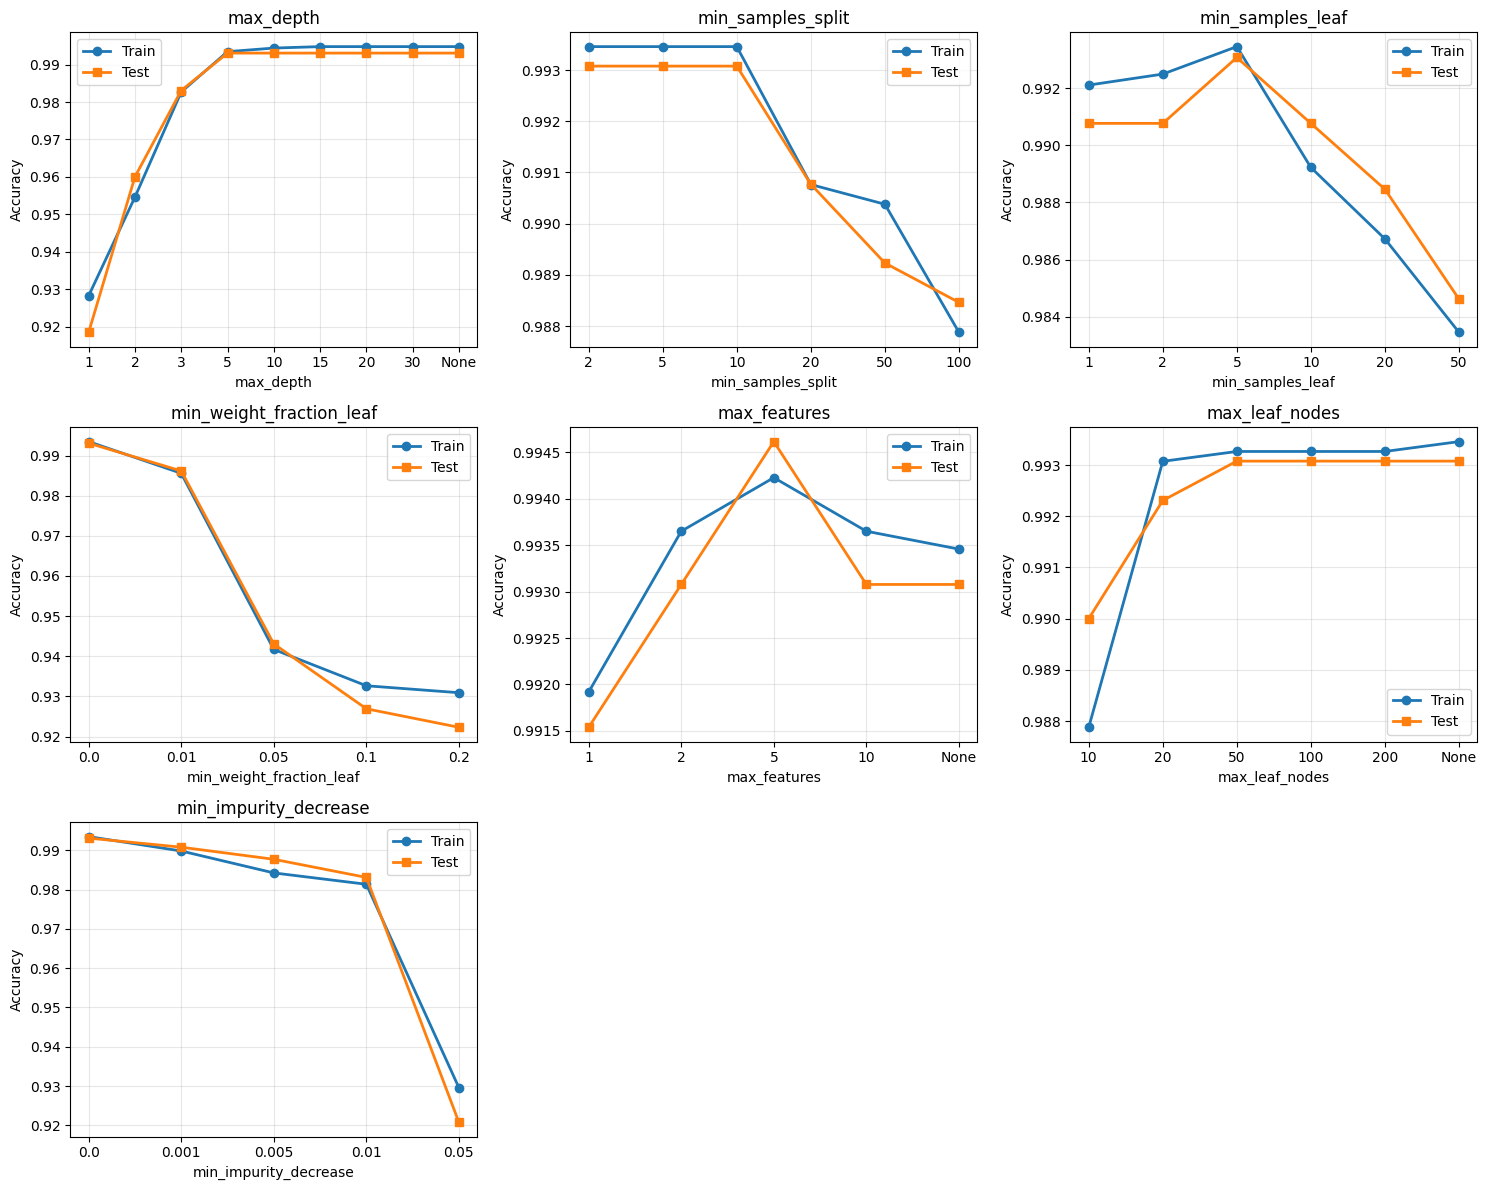

In [6]:

param_ranges = {
    'max_depth': [1, 2, 3, 5, 10, 15, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 2, 5, 10, 20, 50],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05, 0.1, 0.2],
    'max_features': [1, 2, 5, 10, None],
    'max_leaf_nodes': [10, 20, 50, 100, 200, None],
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.05]
}

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, (param_name, param_values) in enumerate(param_ranges.items()):
    train_scores = []
    test_scores = []
    
    for value in param_values:
        '''
        Creates a model with all the values in hyperparameters except 
        the one tested which is taken from a loop over param_ranges
        '''
        params = hyperparameters.copy()
        params[param_name] = value
        
        model = RandomForestClassifier(**params, random_state=42)
        model.fit(X_train, y_train)
        
        train_scores.append(accuracy_score(y_train, model.predict(X_train)))
        test_scores.append(accuracy_score(y_test, model.predict(X_test)))
    
    # Plot
    x_labels = [str(v) for v in param_values]
    x_pos = range(len(param_values))
    
    axes[idx].plot(x_pos, train_scores, 'o-', label='Train', linewidth=2)
    axes[idx].plot(x_pos, test_scores, 's-', label='Test', linewidth=2)
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(x_labels)
    axes[idx].set_xlabel(param_name)
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'{param_name}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Remove extra subplots
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

plt.tight_layout()
plt.show()

#### Hyperparameter Importance

The hyperparameter analysis plots follow similar curves to the Decision Tree model however there are a few things to note. Firstly, the max depth parameter causes significantly less overfit after the depth of 5, same is valid for min samples split before the value 10 and with every other parameter across the board (the curves follow each other more closely).This is likely due to factors such as ensemble averaging and feature randomness which make the Random Forest model more robust to overfitting. However i noticed that this model is more prone to underfitting with max features val 5 and min samples leaf val 5 confirming my claim.


In [10]:
X = df.drop('type_white', axis=1)
y = df['type_white']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hyperparameters =  {
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'min_weight_fraction_leaf': 0.0,
    'max_features': 5,
    'max_leaf_nodes': 50,
    'min_impurity_decrease': 0.0
}

model = RandomForestClassifier(random_state=42, **hyperparameters).fit(X_train, y_train)
train_score = accuracy_score(y_train, model.predict(X_train))
test_score = accuracy_score(y_test, model.predict(X_test))

print(f"Train Accuracy: {train_score:.4f} --- Test Accuracy: {test_score:.4f}")

Train Accuracy: 0.9944 --- Test Accuracy: 0.9946


### Bayesian Search CV

In [25]:
param_ranges = {
    'max_depth': (1,30),
    'min_samples_split': (2,100),
    'min_samples_leaf': (1,50),
    'min_weight_fraction_leaf': (0.0,0.2),
    'max_features': (1,10),
    'max_leaf_nodes': (10,200),
    'min_impurity_decrease': (0.0,0.05)
}

bayes_search = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    param_ranges,
    n_iter=30,  
    cv=3,     
    random_state=42,
    n_jobs=-1
)

bayes_search.fit(X_train, y_train)

print(f"Best CV score: {bayes_search.best_score_:.4f}")
print(f"Best params: {bayes_search.best_params_}")
print(f"Test accuracy: {bayes_search.score(X_test, y_test):.4f}")

Best CV score: 0.9931
Best params: OrderedDict([('max_depth', 22), ('max_features', 4), ('max_leaf_nodes', 175), ('min_impurity_decrease', 0.0), ('min_samples_leaf', 4), ('min_samples_split', 7), ('min_weight_fraction_leaf', 0.0)])
Test accuracy: 0.9954


#### Conclusion

| Method          | Train Accuracy | Test Accuracy | CV Score |
|-----------------|----------------|---------------|----------|
| Baseline   | 0.9935         | 0.9931        | -        |
| Manual Tuning  | 0.9944      | 0.9946        | -        |
| Bayesian Search   | -              | 0.9954        | 0.9931   |
| Decision Tree (Best) | 0.9813    | 0.9862        | -        |


Random forest outperformed the decision tree model on the same dataset with a test accuracy of 0.9954 compared to 0.9862 for the best result obtained. In this notebook we also looked at a different method of hyperparameter tuning, Bayesian Search CV, which in contrast to the previous notebook and the random search tuning proved to be more effective than manual tuning. We've also looked at how the random forest method is useful in identifying the most important features using gini importance and observed how its different to comparing correlation coefficients which in the previous notebook highlighted a different set of 2 most important features.
Overall its safe to assume that the random forest model is a more powerful model than decision trees and that it overfits less due to its ensemble nature and randomness introduced in the process.